# Monthly sea ice extent

Sea Ice Extent (SIE) is defined as the area covered by a significant amount of sea ice, that is the area of ocean covered with more than 15% Sea Ice Concentration (SIC).

The European Organisation for the Exploitation of Meteorological Satellites (EUMETSAT) is an intergovernmental organisation created through an international convention agreed by a current total of 30 European Member States. EUMETSAT Ocean and Sea Ice Satellite Application Facility (OSISAF) publishes a Global Sea Ice Concentration data set that spans 1979 through the present. The data are generated using brightness temperature measurements the Scanning Multichannel Microwave Radiometer (SMMR), the Special Sensor Microwave/Imager (SSM/I), and the Special Sensor Microwave Imager/Sounder (SSMIS) sensors aboard various Nimbus and Defense Meteorological Satellite Program (DMSP) satellites. The OSISAF monthly SIE values are computed as averages of the daily SIE values, also using the interpolated daily values.

The sea ice extent data is available for download here: https://osisaf-hl.met.no/v2p1-sea-ice-index

This notebook will model the monthly sea ice extent data over time for the Arctic and Antarctic separately using through an approximation of Gaussian Processes known as Hilbert Space Gaussian Processes (HSGP) using the Bambi library, following this [tutorial](https://bambinos.github.io/bambi/notebooks/hsgp_1d.html).

## Set up

In [2]:
import requests
from netCDF4 import Dataset
import xarray as xr
import pandas as pd
import numpy as np
import pymc as pm
import preliz as pz
import arviz as az
import bambi as bmb
import pytensor.tensor as pt
import matplotlib.pyplot as plt
import seaborn as sns
import calendar
from pandas.api.types import CategoricalDtype

In [3]:
def load_data(url):
    content = requests.get(url).content
    nc = Dataset('anynamehere', memory=content)
    data = xr.open_dataset(xr.backends.NetCDF4DataStore(nc))
    df = data.to_dataframe().reset_index()
    df = df.query("nv == 1").copy()
    df['month'] = df['time_bounds'].apply(lambda x: x.month)
    df['year'] = df['time_bounds'].apply(lambda x: x.year)
    df["month"] = pd.Categorical(df["month"])
    df = df.set_index("time_bounds")

    # Impute missing values using adjacent same month values
    missing_values = df[df['sie'].isna()]
    for i in missing_values.index:
        prev_year_month = i - pd.DateOffset(years=1)
        prev_year_month_value = df.loc[prev_year_month]['sie']
        next_year_month = i + pd.DateOffset(years=1)
        next_year_month_value = df.loc[next_year_month]['sie']
        average_value = np.mean([prev_year_month_value, next_year_month_value])
        df.loc[i, 'sie'] = average_value
    return df


## Northern Hemisphere

In [4]:
url = "https://thredds.met.no/thredds/fileServer/osisaf/met.no/ice/index/v2p1/nh/osisaf_nh_sie_monthly.nc"
df_north = load_data(url)

In [5]:
share_cov = False
m = 5
c = 1.5

prior_hsgp = {
    "ell": bmb.Prior("HalfNormal", sigma=10), # lengthscale
    "sigma": bmb.Prior("HalfNormal", sigma=10) # amplitude
}
priors = {
    f"hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model_north = bmb.Model(f"sie ~ 0 + hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})", df_north, priors=priors)
model_north.set_alias({f"hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})": "hsgp"})
model_north

       Formula: sie ~ 0 + hsgp(year, by=month, m=5, c=1.5, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 536
        Priors: 
    target = mu
        HSGP contributions
            hsgp(year, by=month, m=5, c=1.5, share_cov=False)
                cov: ExpQuad
                ell ~ HalfNormal(sigma: 10.0)
                sigma ~ HalfNormal(sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

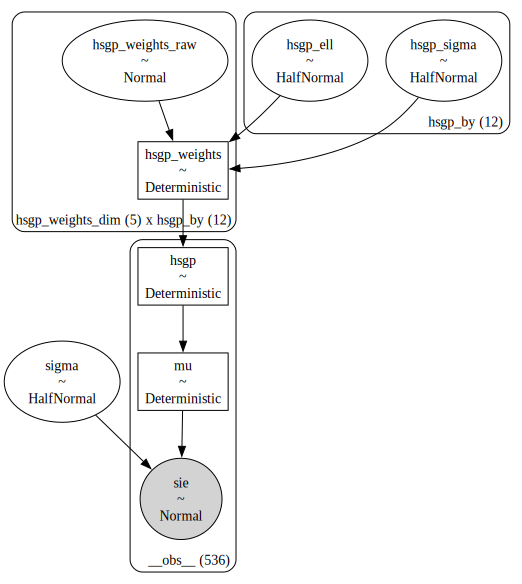

In [6]:
model_north.build()
model_north.graph()

In [7]:
idata_north = model_north.fit(target_accept=0.95, random_seed=121195)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp_sigma, hsgp_ell, hsgp_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 405 seconds.
Chain 0 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 1 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 2 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.
Chain 3 reached the maximum tree depth. Increase `max_treedepth`, increase `target_accept` or reparameterize.


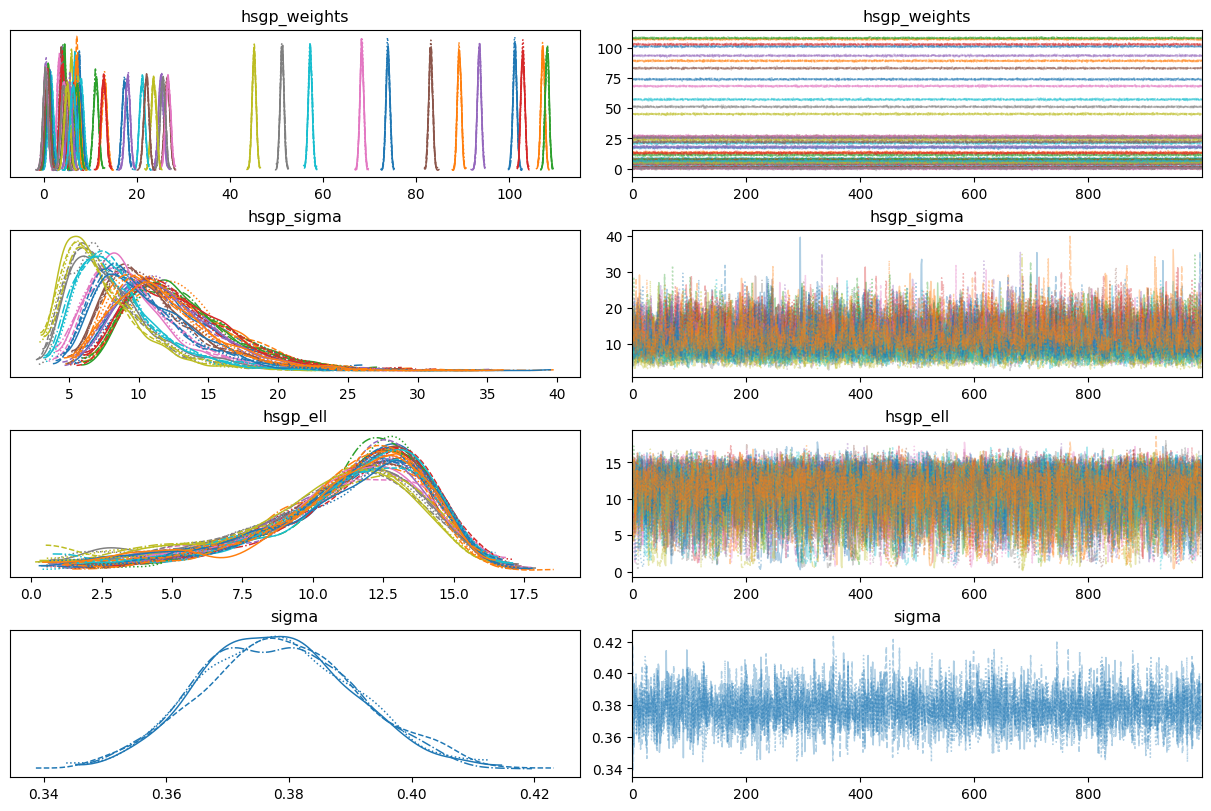

In [8]:
az.plot_trace(
    idata_north, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "sigma"], 
    backend_kwargs={"layout": "constrained"}
);

In [26]:
df_north.head()

,time,nv,sic_threshold,lat,lat_bounds,lon,lon_bounds,area,sie,month,year
time_bounds,,,,,,,,,,,
1979-01-31,1979-01-16,1,0.15,90.0,90.0,0.0,180.0,b'NH',15.565635,1,1979
1979-02-28,1979-02-16,1,0.15,90.0,90.0,0.0,180.0,b'NH',16.287846,2,1979
1979-03-31,1979-03-16,1,0.15,90.0,90.0,0.0,180.0,b'NH',16.444950,3,1979
1979-04-30,1979-04-16,1,0.15,90.0,90.0,0.0,180.0,b'NH',15.619396,4,1979
1979-05-31,1979-05-16,1,0.15,90.0,90.0,0.0,180.0,b'NH',14.086220,5,1979


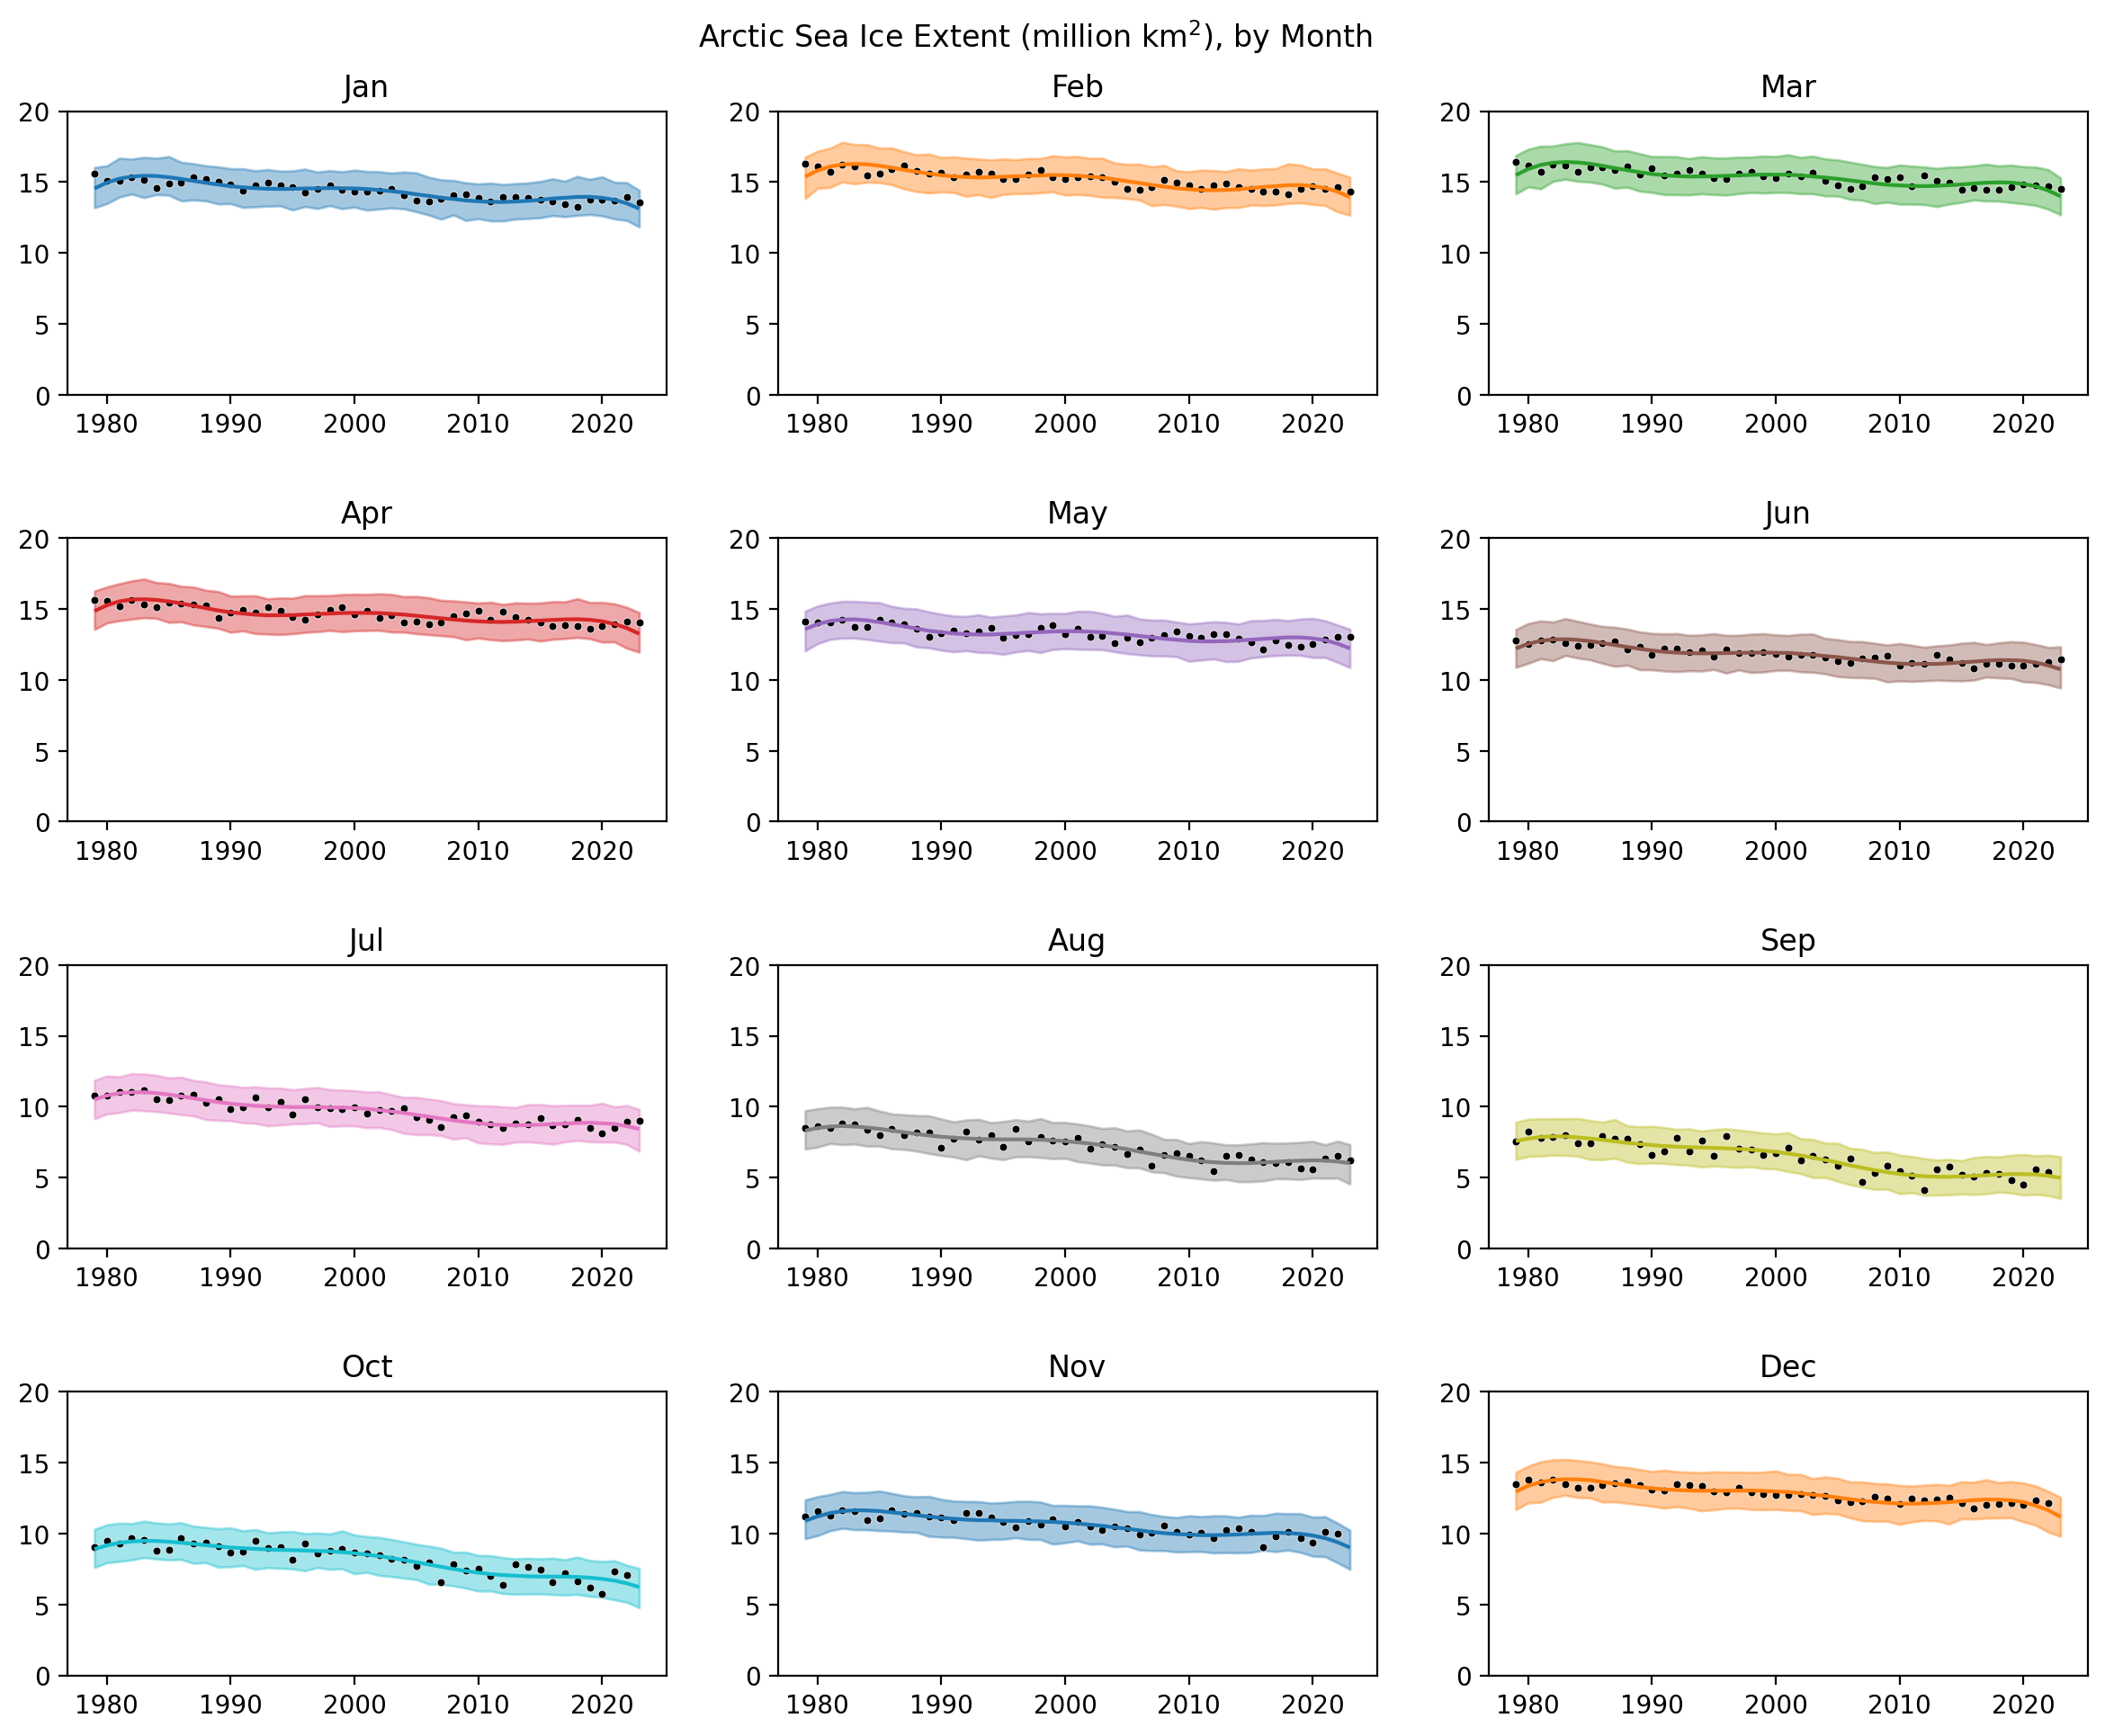

In [38]:
fig, ax = plt.subplots(4, 3, figsize = (12, 10), dpi=200)

fig.suptitle("Arctic Sea Ice Extent (million km$^2$), by Month")

bmb.interpret.plot_predictions(
    model=model_north, 
    idata=idata_north, 
    conditional={"year": range(1979, 2024), "month": sorted(df_north["month"].unique(), reverse=False)},
    legend=False,
    prob=0.999,
    pps=True,
    subplot_kwargs={"group": "month", "panel": "month"},
    fig_kwargs={"figsize": (20, 8), "sharey": True},
    ax=ax
)
plt.tight_layout();
month_num = 0
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for a in ax.flatten():
    a.set_ylim(0, 20)
    a.set_title(month_names[month_num])
    month_num += 1
    sns.scatterplot(data=df_north.query(f'month == {month_num}'), x='year', y='sie', ax=a, color='black', s=10);
    a.set_ylabel("")
    a.set_xlabel("")

## Southern Hemisphere

In [10]:
url = "https://thredds.met.no/thredds/fileServer/osisaf/met.no/ice/index/v2p1/sh/osisaf_sh_sie_monthly.nc"
df_south = load_data(url)

In [11]:
#share_cov: Determines whether the same covariance function is shared across all groups.
share_cov = False

# m: The number of basis vectors
m = 5

# c: The proportion extension factor
c = 1.5

prior_hsgp = {
    # lengthscale
    "ell": bmb.Prior("HalfNormal", sigma=10), 
    # amplitude
    "sigma": bmb.Prior("HalfNormal", sigma=10) 
}
priors = {
    f"hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model_south = bmb.Model(f"sie ~ 0 + hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})", df_south, priors=priors)
model_south.set_alias({f"hsgp(year, by=month, m={m}, c={c}, share_cov={share_cov})": "hsgp"})
model_south

       Formula: sie ~ 0 + hsgp(year, by=month, m=5, c=1.5, share_cov=False)
        Family: gaussian
          Link: mu = identity
  Observations: 536
        Priors: 
    target = mu
        HSGP contributions
            hsgp(year, by=month, m=5, c=1.5, share_cov=False)
                cov: ExpQuad
                ell ~ HalfNormal(sigma: 10.0)
                sigma ~ HalfNormal(sigma: 10.0)
        
        Auxiliary parameters
            sigma ~ HalfNormal(sigma: 10.0)

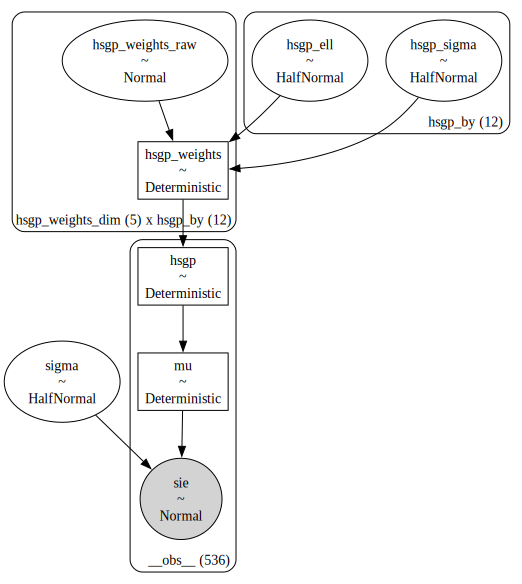

In [12]:
model_south.build()
model_south.graph()

In [13]:
idata_south = model_south.fit(target_accept=0.95, random_seed=121195)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, hsgp_sigma, hsgp_ell, hsgp_weights_raw]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 393 seconds.


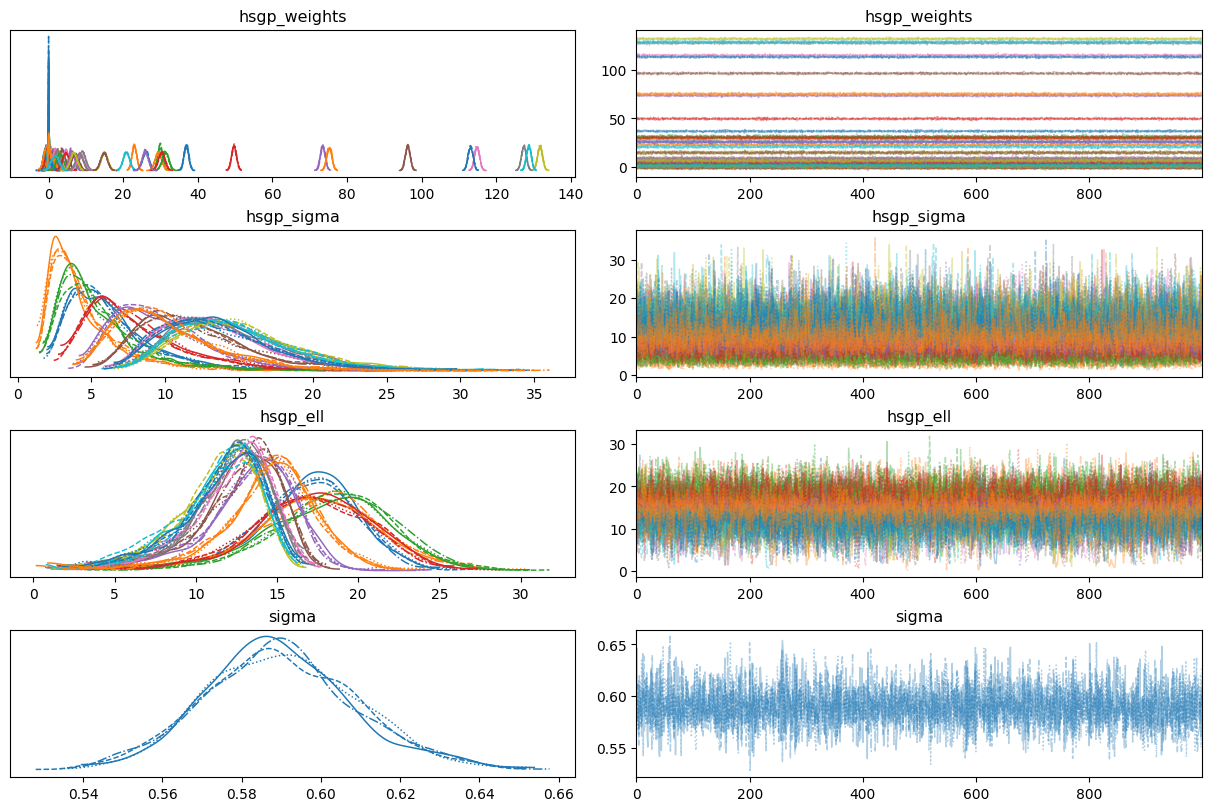

In [14]:
az.plot_trace(
    idata_south, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "sigma"], 
    backend_kwargs={"layout": "constrained"}
);

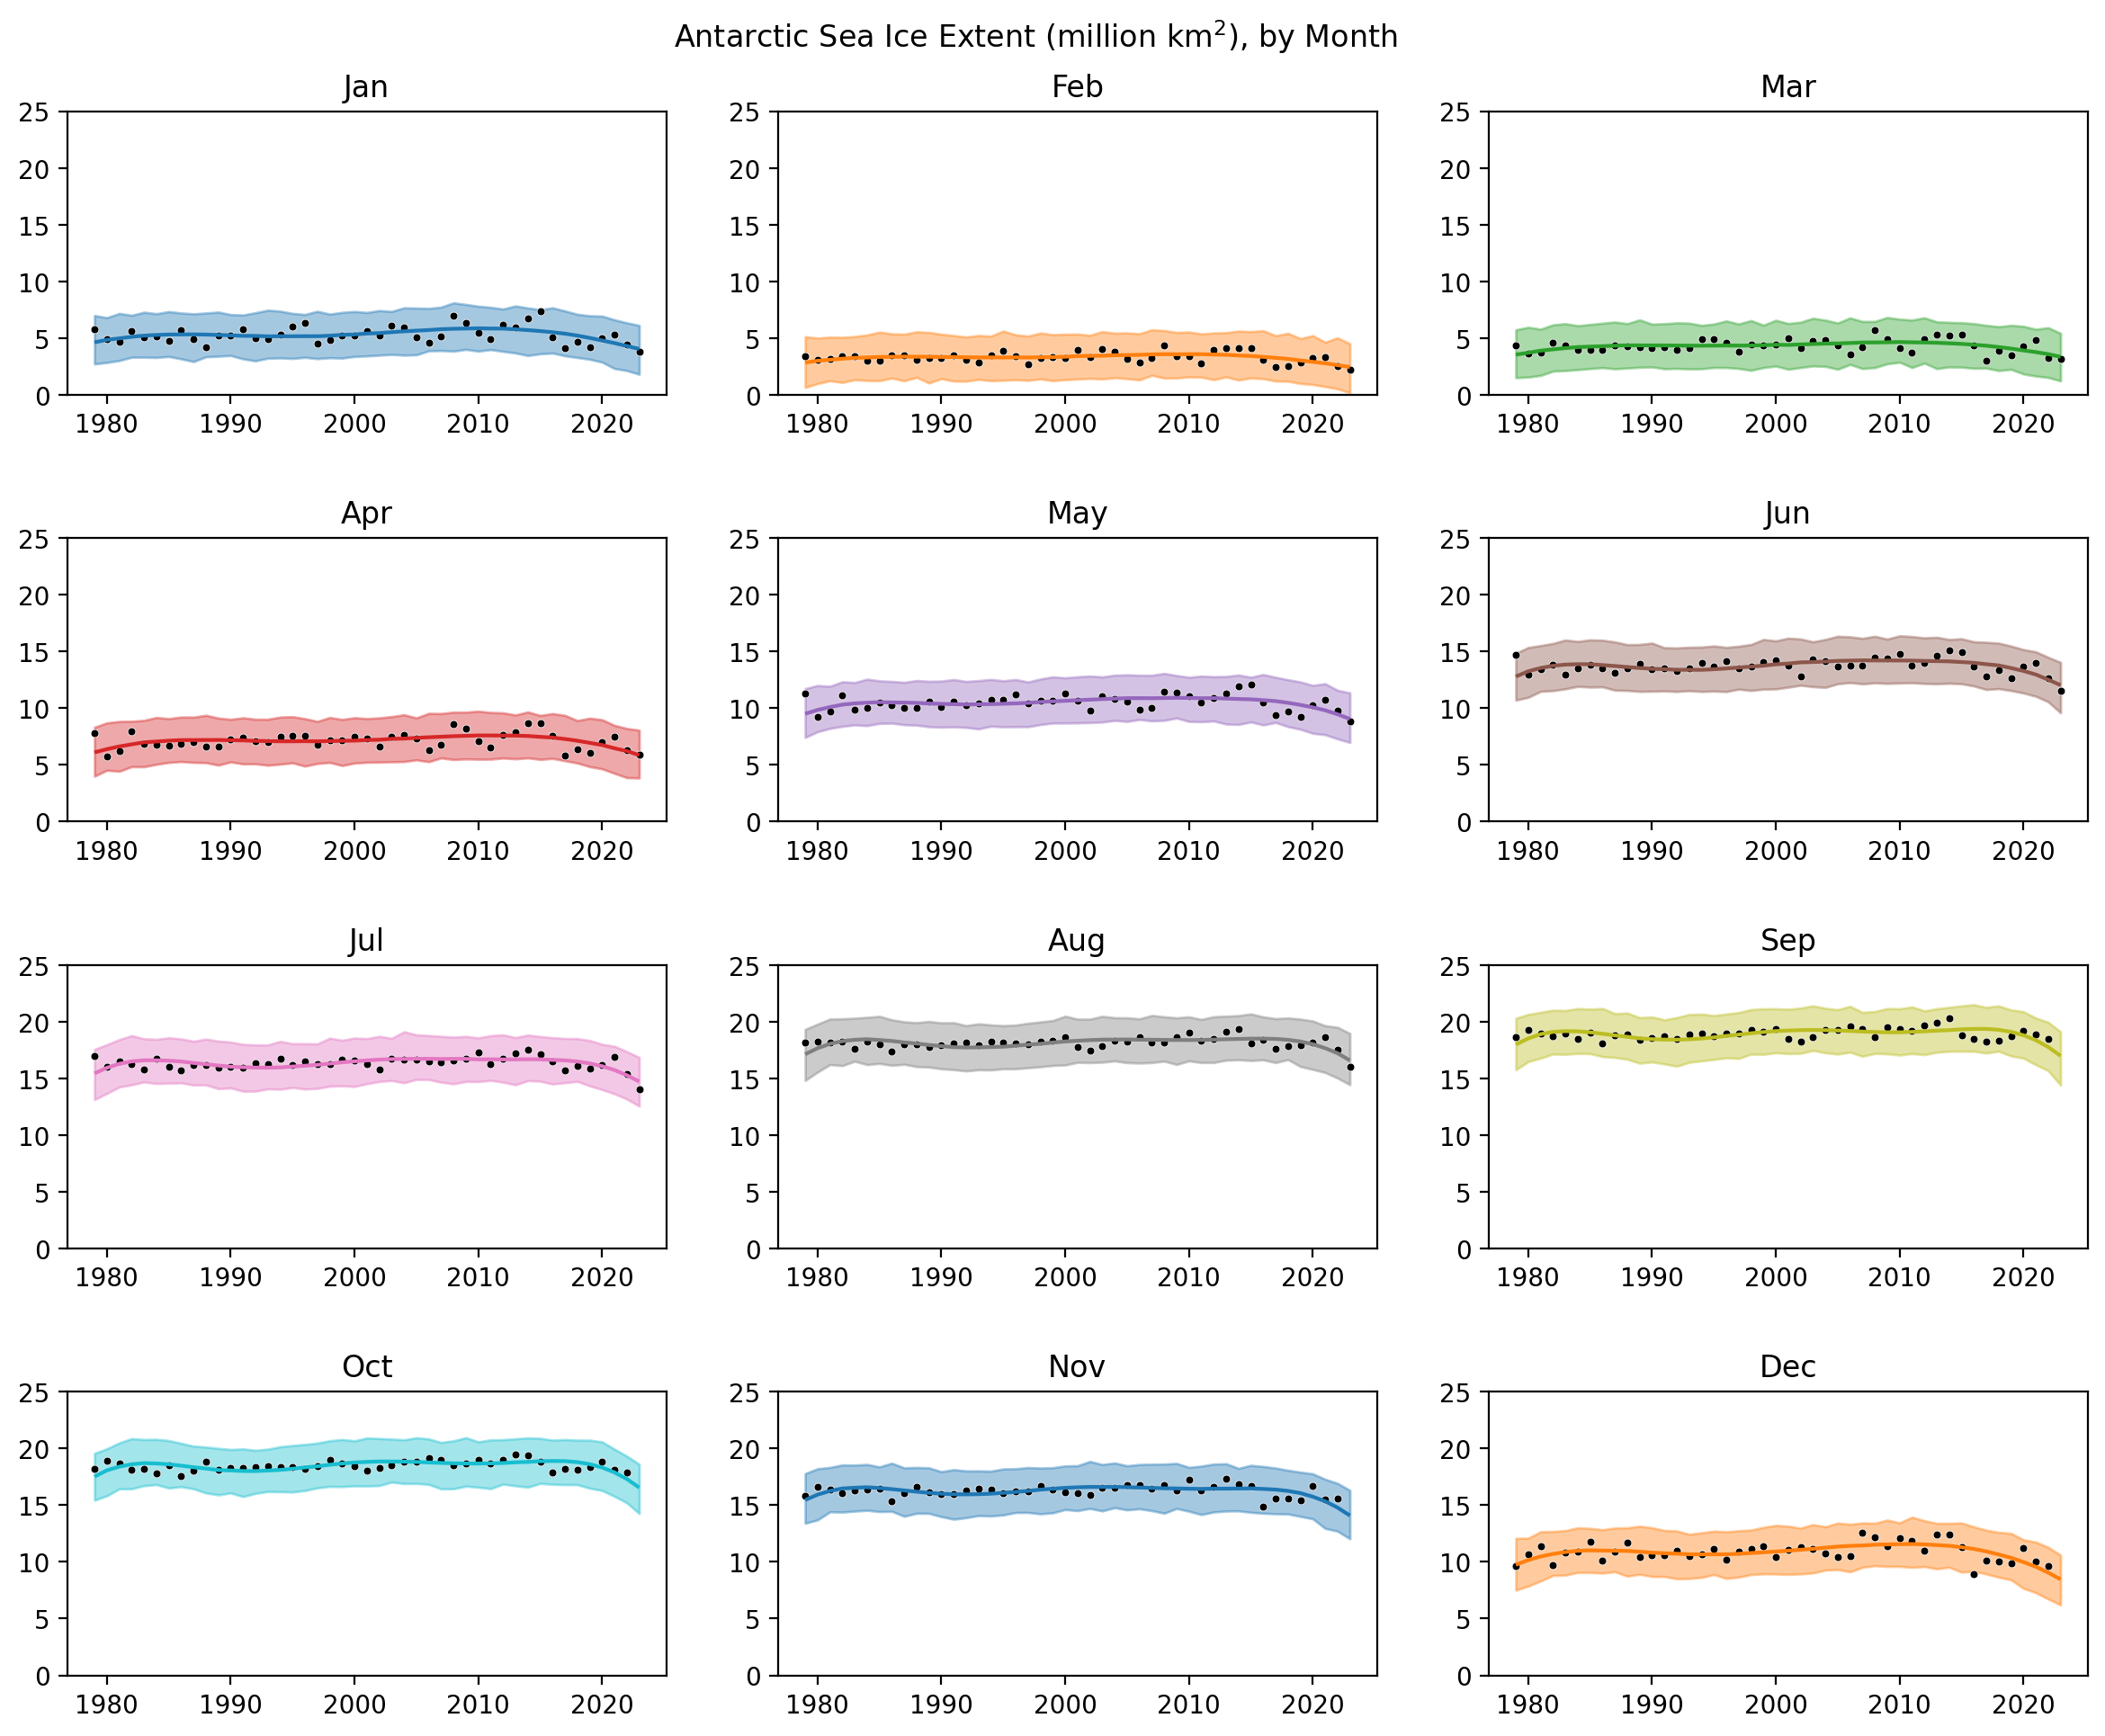

In [39]:
fig, ax = plt.subplots(4, 3, figsize = (12, 10), dpi=200)

fig.suptitle("Antarctic Sea Ice Extent (million km$^2$), by Month")

bmb.interpret.plot_predictions(
    model=model_south, 
    idata=idata_south, 
    conditional={"year": range(1979, 2024), "month": sorted(df_south["month"].unique(), reverse=False)},
    legend=False,
    prob=0.999,
    pps=True,
    subplot_kwargs={"group": "month", "panel": "month"},
    fig_kwargs={"figsize": (20, 8), "sharey": True},
    ax=ax
)
plt.tight_layout();
month_num = 0
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
for a in ax.flatten():
    a.set_ylim(0, 25)
    a.set_title(month_names[month_num])
    month_num += 1
    sns.scatterplot(data=df_south.query(f'month == {month_num}'), x='year', y='sie', ax=a, color='black', s=10)
    a.set_ylabel("")
    a.set_xlabel("");